In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

To illustrate the functionality of the tool, consider the problem of identifying and extracting data from email headers included in the body of an email.

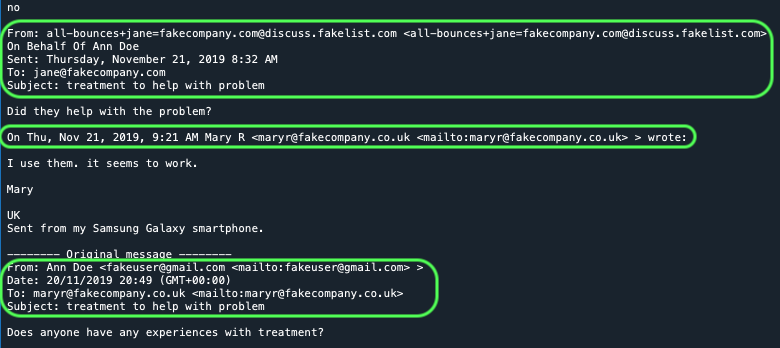

Some headers follow the pattern: On...date...time...email...wrote:

The following code identifies the pattern and extract date, time and email.

In [1]:
import quant
from quant.tagger import Tagger,lit
from quant.query import Query
from jn_regex import DATE,TIME,EMAIL

EML_FILE = 'email.txt'
TXT_PATH='./'
f = open(  TXT_PATH+EML_FILE, 'r')
txt = f.read() 
tagged_email = Tagger(txt)
tagged_email.tagRE('DATE', DATE)
tagged_email.tagRE('TIME', TIME)
tagged_email.tagRE('EMAIL', EMAIL)
tags =[lit('on'), 'DATE', 'TIME', 'EMAIL', lit('wrote:')]
pred = 'seq_before(0,1,2,3,4) and dist(0,4)<100'
qry = Query(tags, pred, tagged_email, [1,2,3])
triplets = qry.execute()
tagged_email.display_tuples(triplets)


ModuleNotFoundError: No module named 'quant'

Previous query results in two tuples: one for each occurrence of email maryr@fakecompany.co.uk

To remove the extra tuple, we constrain the query to select only one of the emails, the one closer to 'wrote:'

In [3]:
pred = 'seq_before(0,1,2,3,4) and dist(3,4) < 10 and dist(0,4)<100'
qry = Query(tags, pred, tagged_email, [1,2,3])
triplets = qry.execute()
tagged_email.display_tuples(triplets)

('thu, nov 21, 2019', '9:21 am ', 'maryr@fakecompany.co.uk')


The following code identifies the pattern: from: ... sent/date: ... date ... time ... to: ... email ... subject: and extracts date, time and email

In [4]:
tagged_email.tagRE('SENT', '(sent:)|(date:)')
tags = [lit('from:'), 'EMAIL', lit('>'), 'SENT', 'DATE', 'TIME', lit('to:'), 'EMAIL', lit('subject:')]
pred = 'seq_before_meets(0,1,2,3,4,5,6,7, 8) and dist(0,8)<350 and dist(1,2) <5 and dist(6,7)<5'
qry = Query(tags, pred, tagged_email, [1,4,5, 7])
triplets = qry.execute()
tagged_email.display_tuples(triplets)

('all-bounces+jane=fakecompany.com@discuss.fakelist.com', 'thursday, november 21, 2019', '8:32 am', 'jane@fakecompany.com')
('fakeuser@gmail.com', '20/11/2019', '20:49 (gmt+00:00)', 'maryr@fakecompany.co.uk')
('fakeuser@gmail.com', '20/11/2019', '20:49 (gmt+00:00)', 'maryr@fakecompany.co.uk')


The reason of the duplicate rows above is because to: appears twice (to:, mailto:)

To skip the 'to:' in 'mailto:', define a new predicate that returns False if text preceeding location is 'mail'

In [5]:
pred = 'seq_before_meets(0,1,2,3,4,5,6,7, 8) and dist(0,8)<350 and dist(1,2) <5 and dist(6,7)<5 and not_preceeded_by_mail(6)'
qry = Query(tags, pred, tagged_email, [1,4,5,7])
qry.UDP('not_preceeded_by_mail', lambda l: tagged_email.text[l[0].start()-4:l[0].start()] != 'mail')
triplets = qry.execute()
tagged_email.display_tuples(triplets)

('all-bounces+jane=fakecompany.com@discuss.fakelist.com', 'thursday, november 21, 2019', '8:32 am', 'jane@fakecompany.com')
('fakeuser@gmail.com', '20/11/2019', '20:49 (gmt+00:00)', 'maryr@fakecompany.co.uk')


To illustrate additional functionality, we consider an electricity bill.
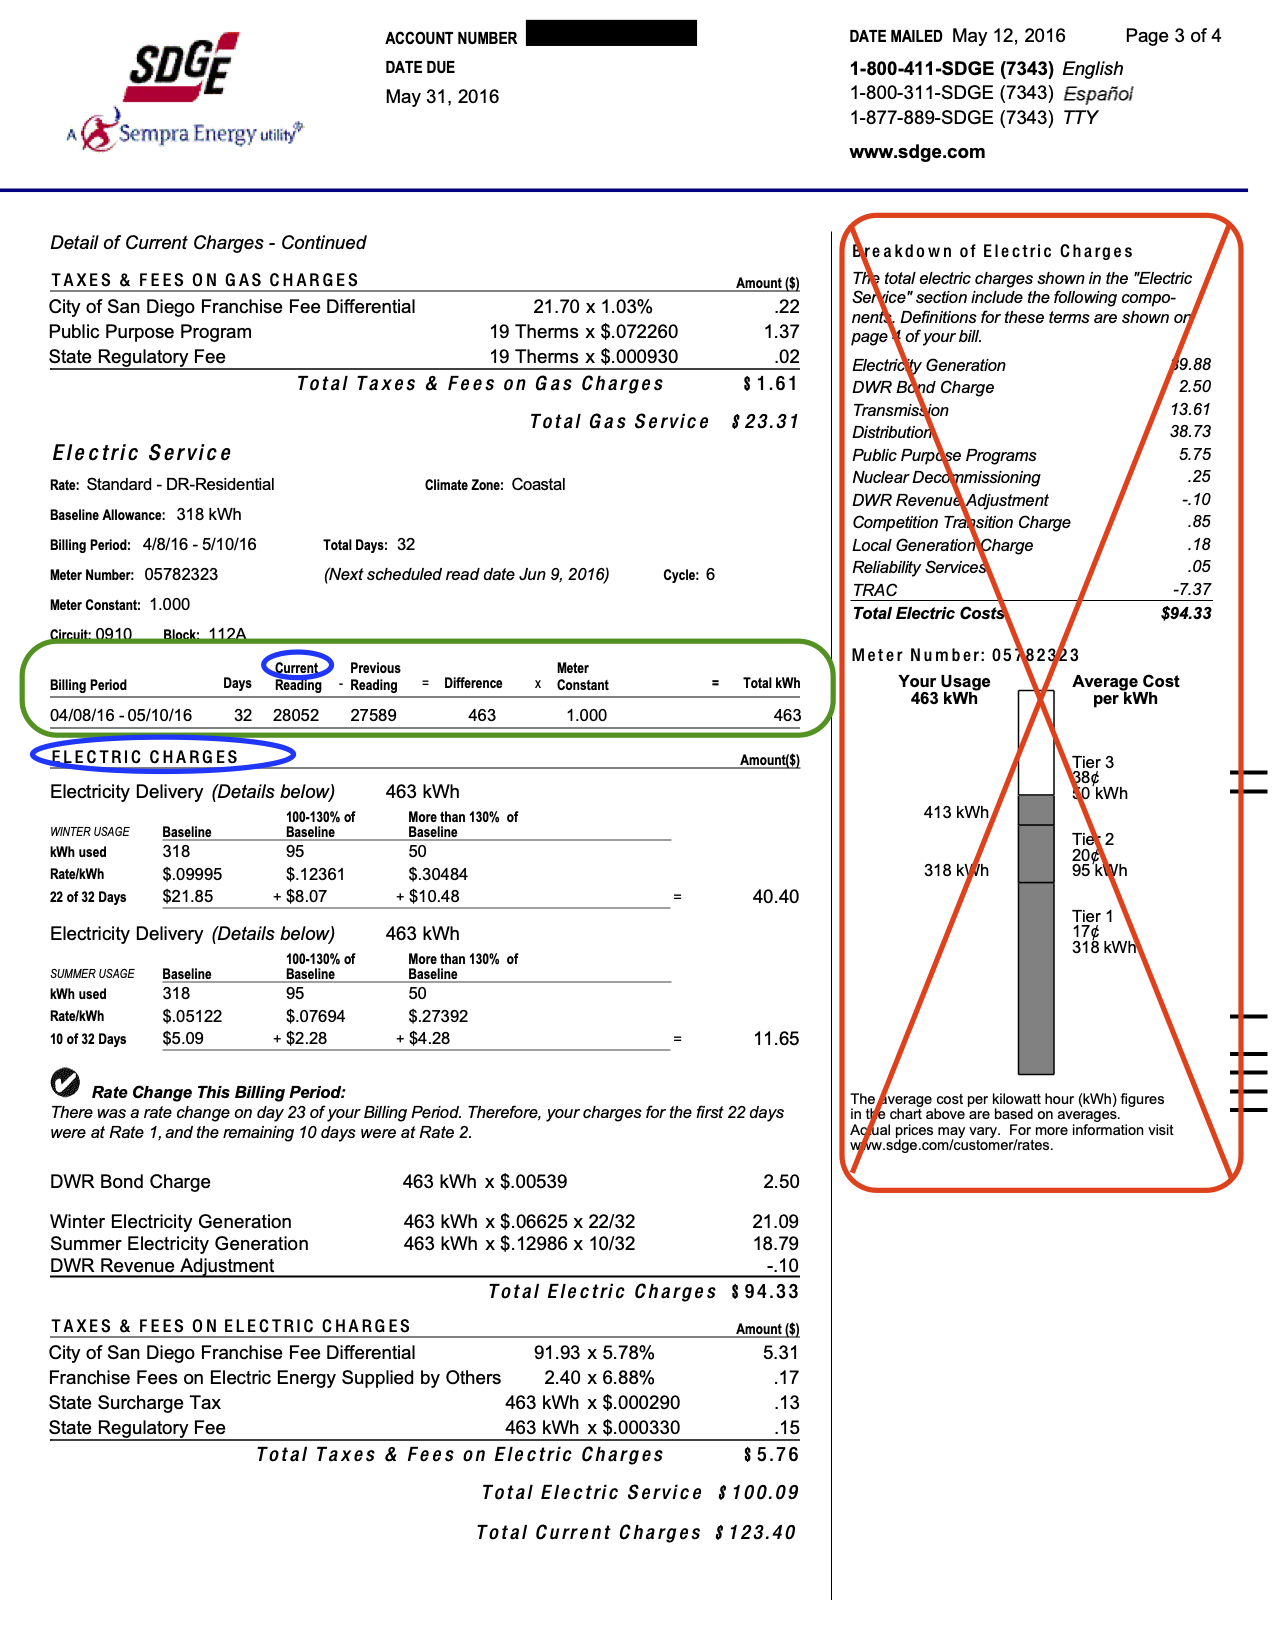
We first get the text with one page of the bill

In [6]:
import quant.utilities as ut
TXT_FILE = 'bill.txt'
f = open(  TXT_PATH+TXT_FILE, 'r')
txt = f.read() 
stat = Tagger(txt) # statement to tag
print(txt)

                                                      ACCOUNT NUMBER            5843 882 258 1                         DATE MAILED May 12, 2016                  Page 3 of 4
                                                      DATE DUE                                                         1-800-411-SDGE (7343) English
                                                      May 31, 2016                                                     1-800-311-SDGE (7343)
                                                                                                                       1-877-889-SDGE (7343) TTY
                                                                                                                       www.sdge.com



Detail of Current Charges - Continued                                                                                  Breakdown of Electric Charges
TAXES & FEES ON GAS CHARGES                                                                               Am

Then, we get rid of column on the right

In [7]:
# get right column of text and mark it as noise
str_in_column = 'the total electric charges shown in the "electric'
stat.tag_list('NOISE', ut.get_column(stat.text, str_in_column))
clean_elec_txt = stat.replace_tag('NOISE', '')
print(clean_elec_txt)

                                                      account number            5843 882 258 1                                           
                                                      date due                                                         
                                                      may 31, 2016                                                     
                                                                                                                       
                                                                                                                       



detail of current charges - continued                                                                                  
taxes & fees on gas charges                                                                               amount ($)   
                                                                                                                       
city of san diego f

Now, we get the text of the table

In [8]:
from quant.loctuple import open_right_span
from quant.loclist import shortest
elec = Tagger(clean_elec_txt)
elec.tagRE('LINE', ut.LINE)
tags = ['LINE', lit('current'), lit('electric charges')]
qry = Query(tags, 'subinterval(1, 0) and before(0, 2)', elec, [0,2])
pairs = qry.execute()
locs = shortest(list(map(open_right_span, pairs)))
table_txt = elec.get_text_loc(locs[0])
print(table_txt)

                                   current       previous                           meter
billing period              days   reading     - reading      =   difference    x   constant          =    total kwh                           
                                                                                                                                                    
04/08/16 - 05/10/16          32    28052         27589                463             1.000                    463




We extract fields from table

In [9]:
from quant.table import get_table 
mytable = get_table(table_txt,2)
print(mytable)

[{'billing period': '04/08/16 - 05/10/16', 'days': '32', 'current reading': '28052', 'previous - reading': '27589', 'difference': '463', 'meter constant': '1.000', 'total kwh': '463'}]
